Machine Learning Job Pair (Classification)
=======

## System Architecture

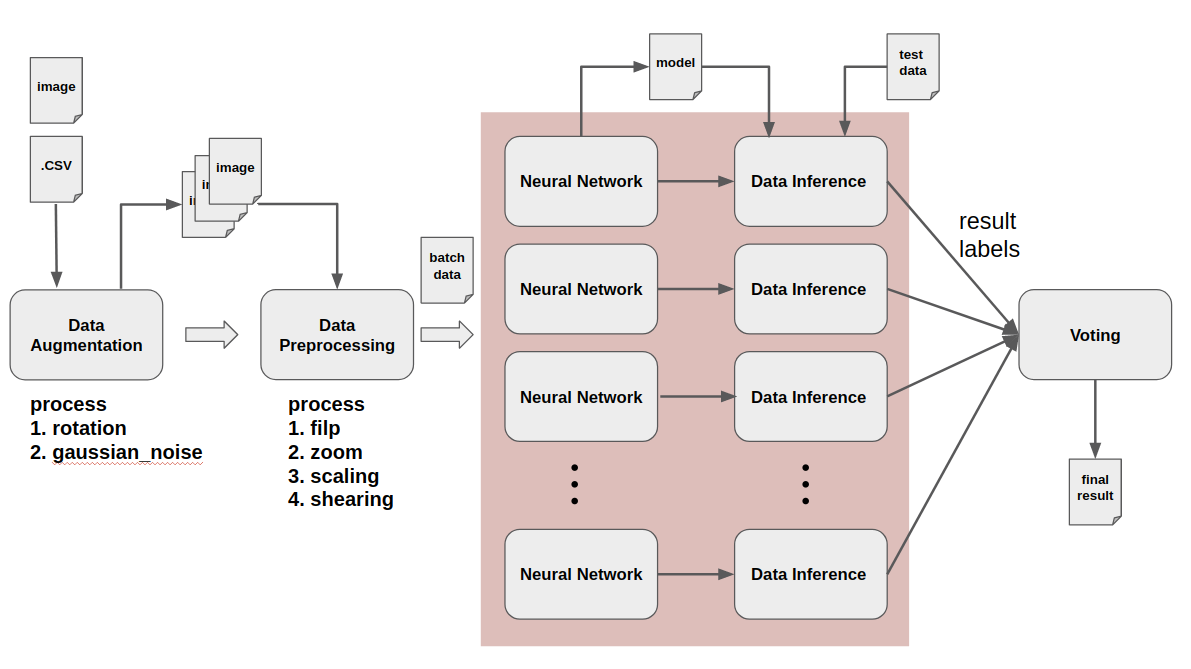

## 1. Requirement
* python 2.x.x                                                         

* Tensorflow 2.0  

* CUDA 10.2  

* Cudnn >= 7.6.2  

* Pillow, SciPy, six, numpy, OpenCV 3.x.x

## 2. Environment  

* Ubuntu 18.04
* Nvidia-docker 2.0.3
* GeForce GTX1070 8G

### Data Augmentation  
* Traing 할수있는 데이터의 수를 늘리고자 회전, 가우시안 노이즈를 적용.

In [7]:
import csv, os
import cv2
import preprocess.augmentation as aug #가우시안 노이즈를 사용하기위한 외부소스

data_file_path = "/data/faces_images" # 데이터의 위치와 훈련데이터 정보가 있는 csv파일 경로
label_file_path = "/data/train_vision.csv" 

f = open('/data/noise_train_vision.csv','w')
wr = csv.writer(f)
wr.writerow(['filename','label'])

with open(label_file_path) as path_list:
    for data in enumerate(path_list):
        if data[0] is 0: continue
        filename, label = data[1].split(",")
        filepath = os.path.join(data_file_path,filename)
        
        ### 가우시안 노이즈 이미지 생성
        img = cv2.imread(filepath)
        noised_img = aug.gaussian_noise(img, mean=0, var =10) 
        
        ### Label파일 생성
        wr.writerow([filename, int(label)])
        cv2.imwrite(os.path.join(data_file_path,'noised_'+filename), noised_img)
        wr.writerow(['noised_'+filename, int(label)])
        
        '''
        for i in range(1,4):
            img = img.rotate(90)
            img.save(os.path.join(data_file_path,'rot'+str(90*i)+'_'+filename))
            wr.writerow(['rot'+str(90*i)+'_'+filename, int(label)])
        '''

### Data Preprocessing
* 주어진 데이터 csv를 참고하여 데이터를 읽은 후 전처리하는 단계입니다.
* keras의 데이터생성 함수의 경우 폴더 내부의 이미지를 읽어들여 Data Generator를 생성하기 때문에 이미지의 파일경로와 라벨을 가지고 데이터를 생성하는 flow_from_mapfile 구현.  
* Feature 잘 분류하기 위해 데이터 처리 과정에서 horizontal flip, zoom, shear, rescale 적용.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os, sys
import numpy as np
import preprocess.image as image
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
import random


data_file_path = "/data/faces_images"
label_file_path = "/data/train_vision.csv"
initial_learning_rate = 0.001 
image_size = 224
class_num = 6
batch_size = 16
epoch = 60

### GPU Memory 사용량을 제어하기 위한 코드 
### 기존의 tensorflow 1.x 버전의 Session을 이용하여 할당하는데 필요한 memory만을 사용.
'''
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config))
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# 프로그램 시작시에 메모리 증가가 설정되어야만 합니다

### 데이터 생성을 위한 path와 label리스트 생성
filenames = []
labels = []
with open(label_file_path) as path_list:
    for data in enumerate(path_list):
        if data[0] is 0:
            continue
            
        filename, label = data[1].split(",")
        filenames.append(os.path.join(data_file_path,filename))
        labels.append(int(label)-1)
        
    '''
    random.seed(1)    
    random.shuffle(filenames)
    random.shuffle(labels)
    '''
    
    print('Found %d images for training.' % (len(filenames)))
    
class_num = list(range(class_num))

'''
Class ImageDataGenerator
- Training에 사용되는 데이터를 생성하고 queue에 전달해주는 iterator.
  전달시 설정한 범위에서 random으로 filp, zoom, shearing을 수행하여 데이터를 보낸다.
'''
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True)

'''
Class DataPathIterator (기존의 DirectoryInterator를 수정)
- flow_from_mapfile의 return값. filename리스트를 읽어 데이터로 변환하며 random index를 통해 Training시 data batch
  를 random하게 구성하여 전달.

argment : 
        get_batches_of_transformed_samples : random index생성 및 이미지 로드를 하며 각 데이터 라벨에 대해 
        one-hot encording을 수행한다.
        
        next : 데이터의 다음 batch를 반환.
'''
train_generator = train_datagen.flow_from_mapfile(class_num,filenames,labels,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            class_mode='categorical')


Found 5850 images for training.


### Neural Network Training
* 전처리한 데이터를 사용하여 신경망을 훈련하는 단계로 훈련에 사용되는 Optimizer 종류, learning rate, epoch수 등을 조정하여 최적의 모델을 만드는 단계입니다.
* tensorflow에서 지원하는 다양한 신경망을 편리하게 사용하기위해 net_factory 구현.
* queue를 사용하여 데이터 흐름을 제어합니다.
* jupyter notebook의 경우 한 셀의 job이 끝나도 GPU에 할당된 메모리를 반환하지 않습니다. Training이 끝난 후 커널을 다시시작 해주세요. 이후 Inference부터 시작합니다.  

In [ ]:
import net.nets_factory as nets_factory
from tensorflow.keras import optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import GeneratorEnqueuer
from tensorflow.keras.utils import OrderedEnqueuer


'''
network list :
    image size(224) : resnet50, resnet101, resnet152, resnet50_v2, resnet101_v2, resnet152_v2, vgg16, vgg19,
                      densenet121, densenet169, densenet201, NASNet
    image size(299) : inception_v3, inception_resnet_v2, xception

'''
network_name = 'resnet152_v2' #사용할 network 입력
save_model_path = "/home/june/model" #model이 저장될 path
network_fn = nets_factory.get_network(network_name)
model = network_fn(include_top=True, weights=None, classes=len(class_num))

'''
scheduler를 이용한 learning rate 적용. overfitting을 방지하기 위해 step수에 따라 
learning rate가 지수적으로 감소합니다.
'''
lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                    decay_steps=10000,
                                                    decay_rate=0.96,
                                                    staircase=True)


'''
network의 weight를 최적화하는 과정에서 사용되는 알고리즘입니다.
주로 사용되는 SGD(Stochastic Gradient Descent), RMSprop(Root Mean Square Propogation) 
Adam(ADAptive with Momentum)을 사용하여 back Propogation을 진행하였습니다.
'''
#optimizer = optimizers.SGD(learning_rate = lr_schedule)
optimizer = optimizers.RMSprop(learning_rate = lr_schedule)
#optimizer = optimizers.Adam(learning_rate = lr_schedule, beta_1 = 0.9,
                            #beta_2 = 0.999, epsilon = 1e-08, decay= 0.)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

'''
iterator를 사용하여 생성한 data batch를 대기열에 넣기위해 queue를 생성합니다.
'''
def create_data_queue(train_generator):
    is_sequence = isinstance(train_generator, Sequence)
    wait_time = 0.01
    if is_sequence:
        enqueuer = OrderedEnqueuer(train_generator,
                                use_multiprocessing=False,
                                shuffle = True)
    else:
        enqueuer = GeneratorEnqueuer(train_generator,
                                use_multiprocessing =False,
                                wait_time = wait_time)
    return enqueuer


# queue생성
enqueuer = create_data_queue(train_generator)
enqueuer.start(workers = 1, max_queue_size=10)
output_generator = enqueuer.get()
accuracy_mean = 0.
current_step = 0
current_epoch = 1
max_iter = len(filenames) / batch_size

'''
입력된 epoch만큼의 훈련을 진행합니다. 
batch별 데이터를 실시간으로 확인하기위해 train_on_batch를 사용.
'''
try:
    while current_step < epoch * max_iter:
        if current_step%max_iter == 0:
            accuracy_mean = 0.
            current_epoch = int(current_step/max_iter)
            
        # queue를 사용한 데이터 제어                
        generator_output = next(output_generator)
        x, y = generator_output
        loss, accuracy = model.train_on_batch(x,y)            
        accuracy_mean = ((accuracy_mean * current_step-(max_iter*current_epoch))+accuracy) / (current_step-(max_iter*current_epoch)+1)
                
        sys.stdout.write('\r>> epoch : %d, loss : %f, accuracy : %f, step : %d/%d ' % (current_epoch, loss, accuracy, current_step, epoch * max_iter))
        sys.stdout.flush()
        current_step += 1
        
        # model save 
        if current_step%1000 ==0 :
            model.save_weights(os.path.join(save_model_path,'%s_%s_%d.ckpt'%('Adam',network_name,current_step)))
            
except Exception as ex:
    print(ex)
    enqueuer.stop(timeout=0.01)
    
enqueuer.stop(timeout=0.01) #queue 종료
model.save_weights(os.path.join(save_model_path,'%s_%s_%d.ckpt'%('rms',network_name,epoch)))
K.clear_session() 

>> epoch : 0, loss : 1.280929, accuracy : 0.437500, step : 460/21937 

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

### Data Inference
* 훈련한 모델을 가지고 테스트를 진행하는 단계입니다.
* 다양한 모델을 학습하고 결과를 놓고 투표하여 최종 Class를 정합니다.

In [21]:
test_file_path = "/data/test_vision.csv"
import net.nets_factory as nets_factory
from tensorflow.keras.preprocessing import image as kimage
import csv, os
import numpy as np
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
import collections


def load_image(image_file_path):
        img = kimage.load_img(image_file_path, target_size=(image_size, image_size))
        x = kimage.img_to_array(img)
        x /= 255.
        return x
    
result = []
result2 = []
data_file_path = "/data/faces_images"
save_model_path = "/home/june/model"
'''
#image_sizes = [224,299,299,224,224]
network_list = ['resnet50_v2', 'inception_resnet_v2', 'inception_v3', 'vgg19','resnet152_v2']
model_list = []
for net in network_list:
    network_fn = nets_factory.get_network(net)
    model_list.append(network_fn(include_top=True, weights=None, classes=6))
'''
network_fn = nets_factory.get_network('resnet50_v2')
#network_fn2 = nets_factory.get_network('inception_resnet_v2')
model = network_fn(include_top=True, weights=None, classes=6)
#model2 = network_fn2(include_top=True, weights=None, classes=6)
#image_size = 224

'''
lr_schedule = optimizers.schedules.ExponentialDecay(0.001,
                                                    decay_steps=15000,
                                                    decay_rate=0.96,
                                                    staircase=True)

#optimizer = optimizers.SGD(learning_rate = lr_schedule)
#optimizer = optimizers.Adagrad(learning_rate = lr_schedule)

optimizer = optimizers.Adam(learning_rate = lr_schedule, beta_1 = 0.9,
                            beta_2 = 0.999, epsilon = 1e-08, decay= 0.)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

#model2.compile(loss='categorical_crossentropy',
                #optimizer=optimizer,
                #metrics=['accuracy'])

'''

model.load_weights(os.path.join(save_model_path,"rms_resnet50_v2_60.ckpt"))
#model2.load_weights(os.path.join(save_model_path,"Adam_inception_resnet_v2_20.ckpt"))
count = collections.Counter()
stack = list(range(6))
with open(test_file_path) as path_list:
    for image_path in enumerate(path_list):
        if image_path[0] is 0 : continue
        img = load_image(os.path.join(data_file_path,image_path[1].split("\n")[0]))
        #img = load_image(os.path.join(data_file_path,image_path[1].split("\n")[0]), 
        #                 target_size=(image_size, image_size))
        x = np.expand_dims(img, axis=0)
        '''
        for model in model_list:
            softmax = model.predict(x, batch_size=1)
            stack[np.asarray(softmax).argmax()] += 1
        result.append(np.asarray(stack).argmax() + 1)
        '''
        softmax = model.predict(x, batch_size=1)
        #softmax2 = model.predict(x, batch_size=1)
        result.append(np.asarray(softmax).argmax() + 1)
        #result2.append(np.asarray(softmax).argmax() + 1)
       
#df = pd.DataFrame(result, columns=['label'])
#df.to_csv("/data/result.csv")
f = open('/data/result_rms_resnet50V2_22.csv','w')
wr = csv.writer(f)
wr.writerow(['prediction'])
for i in result:
    wr.writerow([i])
f.close()

W1216 08:06:45.014759 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer
W1216 08:06:45.016041 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.iter
W1216 08:06:45.017241 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.decay
W1216 08:06:45.018474 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.momentum
W1216 08:06:45.019676 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.rho
W1216 08:06:45.020934 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-0.kernel
W1216 08:06:45.021678 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-0.bias
W1216 08:06:45.023062 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-1.gamma
W1216 08:06:

W1216 08:06:45.087963 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-29.beta
W1216 08:06:45.089190 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-30.kernel
W1216 08:06:45.090419 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-31.gamma
W1216 08:06:45.091646 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-31.beta
W1216 08:06:45.092881 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-32.kernel
W1216 08:06:45.094100 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-32.bias
W1216 08:06:45.095309 139875198887744 util.py:144] Unresolved object in check

W1216 08:06:45.154834 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-62.gamma
W1216 08:06:45.156038 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-62.beta
W1216 08:06:45.157480 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-63.kernel
W1216 08:06:45.158777 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-63.bias
W1216 08:06:45.160068 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-64.gamma
W1216 08:06:45.161288 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-64.beta
W1216 08:06:45.162918 139875198887744 util.py:144] Unresolved object in checkp

W1216 08:06:45.224212 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-94.kernel
W1216 08:06:45.225788 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-94.bias
W1216 08:06:45.227180 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-95.gamma
W1216 08:06:45.228446 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-95.beta
W1216 08:06:45.229775 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-96.kernel
W1216 08:06:45.231240 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-97.gamma
W1216 08:06:45.232465 139875198887744 util.py:144] Unresolved object in chec

W1216 08:06:45.310437 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-18.beta
W1216 08:06:45.311749 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-19.kernel
W1216 08:06:45.313136 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-19.bias
W1216 08:06:45.314353 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-20.gamma
W1216 08:06:45.315531 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-20.beta
W1216 08:06:45.316737 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-21.kernel
W1216 08:06:45.317941 139875198887744 util.py:144] Unresolved object in check

W1216 08:06:45.377151 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-50.bias
W1216 08:06:45.378705 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-51.kernel
W1216 08:06:45.380292 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-51.bias
W1216 08:06:45.381601 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-52.gamma
W1216 08:06:45.382919 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-52.beta
W1216 08:06:45.384239 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-53.kernel
W1216 08:06:45.385417 139875198887744 util.py:144] Unresolved object in check

W1216 08:06:45.449434 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-82.beta
W1216 08:06:45.450648 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-83.kernel
W1216 08:06:45.451854 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-84.gamma
W1216 08:06:45.453063 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-84.beta
W1216 08:06:45.454278 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-85.kernel
W1216 08:06:45.455470 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-86.gamma
W1216 08:06:45.456896 139875198887744 util.py:144] Unresolved object in chec

W1216 08:06:45.536257 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-7.kernel
W1216 08:06:45.537456 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-7.bias
W1216 08:06:45.538665 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-8.gamma
W1216 08:06:45.540075 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-8.beta
W1216 08:06:45.541529 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-9.kernel
W1216 08:06:45.542733 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-10.gamma
W1216 08:06:45.544158 139875198887744 util.py:144] Unresolved object in checkpoin

W1216 08:06:45.606791 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-39.gamma
W1216 08:06:45.607965 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-39.beta
W1216 08:06:45.609302 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-40.kernel
W1216 08:06:45.610512 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-41.gamma
W1216 08:06:45.611804 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-41.beta
W1216 08:06:45.613094 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-42.kernel
W1216 08:06:45.614361 139875198887744 util.py:144] Unresolved object in chec

W1216 08:06:45.676640 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-71.kernel
W1216 08:06:45.677946 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-72.gamma
W1216 08:06:45.679192 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-72.beta
W1216 08:06:45.680428 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-73.kernel
W1216 08:06:45.681606 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-74.gamma
W1216 08:06:45.683124 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-74.beta
W1216 08:06:45.684442 139875198887744 util.py:144] Unresolved object in chec

W1216 08:06:45.745759 139875198887744 util.py:152] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#loading_mechanics for details.
W1216 08:06:45.765134 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer
W1216 08:06:45.766840 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.iter
W1216 08:06:45.768249 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.decay
W1216 08:06:45.769467 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer.momentum
W1216 08:06:45.770675 139875198887744 util.py:144] Unresolved object in checkpoint: (root

W1216 08:06:45.833515 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-27.beta
W1216 08:06:45.834708 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-28.kernel
W1216 08:06:45.835943 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-29.gamma
W1216 08:06:45.837126 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-29.beta
W1216 08:06:45.838326 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-30.kernel
W1216 08:06:45.839889 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-31.gamma
W1216 08:06:45.841438 139875198887744 util.py:144] Unresolved object in chec

W1216 08:06:45.904149 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-60.gamma
W1216 08:06:45.905621 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-60.beta
W1216 08:06:45.906899 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-61.kernel
W1216 08:06:45.908190 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-62.gamma
W1216 08:06:45.909532 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-62.beta
W1216 08:06:45.910785 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-63.kernel
W1216 08:06:45.912081 139875198887744 util.py:144] Unresolved object in chec

W1216 08:06:45.975157 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-92.kernel
W1216 08:06:45.976898 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-93.gamma
W1216 08:06:45.978148 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-93.beta
W1216 08:06:45.979480 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-94.kernel
W1216 08:06:45.980698 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-94.bias
W1216 08:06:45.981942 139875198887744 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'rms' for (root).layer_with_weights-95.gamma
W1216 08:06:45.983129 139875198887744 util.py:144] Unresolved object in chec